In [ ]:
!pip install transformers -U

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
import os
import warnings
warnings.filterwarnings("ignore")

# specify the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
# read the data
path = "/kaggle/input/imdb-dataset/IMDB Dataset.csv"
df = pd.read_csv(path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
# check the data if there is null object
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [9]:
# dropped the duplicate values in review column
df = df.drop_duplicates('review')

In [10]:
nltk.download('stopwords')
sw = stopwords.words('english')

def clean_text(text, clean_stopword = True):

    text = text.lower() 

    html=re.compile(r'<[^>]+>')

    text = html.sub(r'',text) #Removing html tags

    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs

    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations

    if clean_stopword:
      text = [word.lower() for word in text.split() if word.lower() not in sw]

      text = " ".join(text) #removing stopwords

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis

    #fix some nots and pronouns
    text = text.replace(" dont ", " do not ")
    text = text.replace(" don't ", " do not ")
    text = text.replace(" doesnt ", " does not ")
    text = text.replace(" doesn't ", " does not ")
    text = text.replace(" wont ", " will not ")
    text = text.replace(" won't ", " will not ")
    text = text.replace(" cant ", " cannot ")
    text = text.replace(" can't ", " cannot ")
    text = text.replace(" couldnt ", " could not ")
    text = text.replace(" couldn't ", " could not ")
    text = text.replace(" shouldnt ", " should not ")
    text = text.replace(" shouldn't ", " should not ")
    text = text.replace(" wouldnt ", " would not ")
    text = text.replace(" wouldn't ", " would not ")
    text = text.replace(" mustnt ", " must not ")
    text = text.replace(" mustn't ", " must not ")
    text = text.replace(" im ", " i am ")
    text = text.replace(" youre ", " you are")
    text = text.replace(" hes ", " he is") # ? he's can be he has as well
    text = text.replace(" shes ", " she is")
    # we are -> we're -> were  ---- were is a valid word
    text = text.replace(" theyre ", " they are")

    text = text.replace(" ive ", " i have ")
    text = text.replace(" youve ", " you have ")
    text = text.replace(" weve ", " we have ")
    text = text.replace(" theyve ", " they have ")

    text = text.replace(" youll ", " you will ")
    text = text.replace(" theyll ", " they will ")
    text = text.replace(" theres ", " there is ")

    return text

# encode positive-negavite labels to 0-1
def encode_labels(data):
    
    data = data.reset_index(drop = True)
      
    for i in range(len(data['sentiment'])):

        if data['sentiment'][i] == 'positive':
            data['sentiment'][i] = 1
        else:
            data['sentiment'][i] = 0
    
    return data

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# get %90 of the data and preprocess for train and val sets
data = df[:45000].copy()

data['review'] = data['review'].apply(lambda x: clean_text(x, clean_stopword=False))
data = encode_labels(data)

In [12]:
from sklearn.model_selection import train_test_split

# set train-val-test splits with %85-%15 ratios 
train_X, val_X, train_y, val_y = train_test_split(data['review'],
                                                  data['sentiment'],
                                                  test_size = 0.15,
                                                  random_state = 42,
                                                 stratify = data['sentiment'])

In [13]:
# checking homogenity of train-val-test sets

print("Ratio of 0 in Train data without stopwords: ", sum(train_y==1)/len(train_y))
print("Ratio of 0 in Validataion data without stopwords: ", sum(val_y==1)/len(val_y))

Ratio of 0 in Train data without stopwords:  0.5020653594771242
Ratio of 0 in Validataion data without stopwords:  0.5020740740740741


In [ ]:
# upload and define the tokenizer and BERT model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased", return_dict = False)

In [15]:
# encode train and validation set with BERT tokenizer

train_tokens = tokenizer.batch_encode_plus(
    train_X.to_list(),
    max_length = 512,
    add_special_tokens = True, # Add '[CLS]' and '[SEP]'
    truncation = True,           # Pad & truncate all sentences.
    padding = True,
    return_attention_mask = True,   # Construct attention masks.
    return_token_type_ids=False
)

val_tokens = tokenizer.batch_encode_plus(
    val_X.to_list(),
    max_length = 512,
    add_special_tokens = True, # Add '[CLS]' and '[SEP]'
    truncation = True,           # Pad & truncate all sentences.
    padding = True,
    return_attention_mask = True,   # Construct attention. masks.
    return_token_type_ids=False
)

In [16]:
# create tensors for train set
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
train_y = torch.tensor(train_y.tolist())
print("train_y:",train_y)
# create tensors for validation set
val_seq = torch.tensor(val_tokens['input_ids'])
val_mask = torch.tensor(val_tokens['attention_mask'])
val_y = torch.tensor(val_y.tolist())
print("val_y:",val_y)

train_y: tensor([0, 0, 1,  ..., 0, 1, 0])
val_y: tensor([0, 1, 1,  ..., 1, 0, 1])


In [17]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [18]:
# freeze all the parameters
for param in bert_model.parameters():
    param.requires_grad = False

In [19]:
import torch.nn as nn

class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
         
        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layers
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512, 1)
        
        # sigmoid activation function
        self.sigmoid = nn.Sigmoid()
        
        # define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask)

        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
         
        # apply sigmoid activation
        x = self.sigmoid(x)
        return x

In [20]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert_model)

# push the model to GPU
model = model.to(device)

In [21]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# loss function
loss_function  = nn.BCELoss()

# number of training epochs
epochs = 30

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, # Default value
                                            num_training_steps=total_steps)

In [22]:
# function to train the model
def train(data):
    
    model.train()
    total_loss, total_accuracy = 0, 0

  
    # iterate over batches
    for step,batch in enumerate(data):
    
        # progress update after every 100 batches.
        if step % 100 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(data)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        # get train data
        sent_id, mask, labels = batch
        labels = labels.unsqueeze(1).float()
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)
        
        # compute the loss between actual and predicted values
        loss = loss_function(preds, labels)

        # add on to the total loss and 
        total_loss += loss.item()
        total_accuracy += (preds.round() == labels).sum().item() / float(preds.shape[0])
        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()
        scheduler.step()

    # compute the average training accuracy and loss of the epoch
    avg_loss = total_loss / len(data)
    avg_acc = total_accuracy / float(len(data)) 
    
    #returns the loss and predictions
    return avg_loss, avg_acc

In [23]:
# function for evaluating the model
def evaluate(data):
  
    print("\nEvaluating...")
    total_loss, total_accuracy = 0, 0
    
    # deactivate dropout layers
    model.eval()

    # iterate over batches
    for step,batch in enumerate(data):
      # Progress update every 50 batches.
      if step % 50 == 0 and not step == 0:

        # Calculate elapsed time in minutes.
        #elapsed = format_time(time.time() - t0)

        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(data)))

      # push the batch to gpu
      batch = [t.to(device) for t in batch]

      sent_id, mask, labels = batch
      labels = labels.unsqueeze(1).float()

      # deactivate autograd
      with torch.no_grad():

        # model predictions
        preds = model(sent_id, mask)
          
        # compute the validation loss between actual and predicted values
        loss = loss_function(preds,labels)
        total_loss += loss.item()
        total_accuracy += (preds.round() == labels).sum().item() / float(preds.shape[0]) 
    
    
    # compute the validation training accuracy and loss of the epoch
    avg_loss = total_loss / len(data)
    avg_acc = total_accuracy / float(len(data)) 
    
    return avg_loss, avg_acc

In [24]:
# some parameters for early stopping
patience = 10
trigger_time = 0

# model save path and file name
save_path = "/kaggle/working/imdb_model.pt"

# set initial loss to infinite
best_valid_loss = float('inf')


# for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    # train model
    train_loss, train_acc = train(train_dataloader)

    # evaluate model
    valid_loss, val_acc = evaluate(val_dataloader)
    
    # apply early stopping by observing validation loss
    if valid_loss >= best_valid_loss:
        trigger_time += 1
        if trigger_time == patience:
            print("----- EARLY STOPPING! -----")
            break
    
    
    
    # print the results 
    print(f'\nTraining Accuracy: {train_acc:.3f} --- Training Loss: {train_loss:.3f}')
    print(f'\nValidation Accuracy: {val_acc:.3f} --- Validation Loss: {valid_loss:.3f}')
    
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
        print("\nThe model is saved!")
        trigger_time = 0
    


 Epoch 1 / 30
  Batch   100  of  1,196.
  Batch   200  of  1,196.
  Batch   300  of  1,196.
  Batch   400  of  1,196.
  Batch   500  of  1,196.
  Batch   600  of  1,196.
  Batch   700  of  1,196.
  Batch   800  of  1,196.
  Batch   900  of  1,196.
  Batch 1,000  of  1,196.
  Batch 1,100  of  1,196.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Accuracy: 0.719 --- Training Loss: 0.548

Validation Accuracy: 0.701 --- Validation Loss: 0.564

The model is saved!

 Epoch 2 / 30
  Batch   100  of  1,196.
  Batch   200  of  1,196.
  Batch   300  of  1,196.
  Batch   400  of  1,196.
  Batch   500  of  1,196.
  Batch   600  of  1,196.
  Batch   700  of  1,196.
  Batch   800  of  1,196.
  Batch   900  of  1,196.
  Batch 1,000  of  1,196.
  Batch 1,100  of  1,196.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Accuracy: 0.766 --- Tra

In [25]:
# extract the test data from %10 original data
data_test = df[45000:].copy()

data_test['review'] = data_test['review'].apply(lambda x: clean_text(x, clean_stopword=False))
data_test = encode_labels(data_test)

test_X, test_y = data_test['review'], data_test['sentiment']

In [26]:
# get tokens of the test set
test_tokens = tokenizer.batch_encode_plus(
    test_X.to_list(),
    max_length = 512,
    add_special_tokens = True, # Add '[CLS]' and '[SEP]'
    truncation = True,           # Pad & truncate all sentences.
    padding = True,
    return_attention_mask = True,   # Construct attn. masks.
    return_token_type_ids=False
)

# for test set
test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
test_y = torch.tensor(test_y)
print("test_y:", test_y)

batch_size = 32

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during testing
test_sampler = SequentialSampler(test_data)

# dataLoader for test set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

test_y: tensor([1, 0, 1,  ..., 0, 0, 0])


In [27]:
# accuracy of the model on test set
_, test_acc = evaluate(test_dataloader)

test_acc


Evaluating...
  Batch    50  of    144.
  Batch   100  of    144.


0.8368055555555556

In [28]:
# define the function to get predictions
def get_predictions(data):
  

    # deactivate dropout layers
    model.eval()


    # empty list to save the model predictions
    total_preds = []
    total_labels = []
    # iterate over batches
    for batch in enumerate(data):
        

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch
        labels = labels.unsqueeze(1).float()

        # deactivate autograd
        with torch.no_grad():
            

            # model predictions
            preds = model(sent_id, mask)
             
            # model predictions are stored on GPU. So, push it to CPU and save them     
            preds = preds.detach().cpu().numpy()
            total_preds+=list(preds.round())
            total_labels+=labels.tolist()
    
    
    return total_preds, total_labels

In [29]:
# get the predictions and true labels for the test set
y_pred, y_true = get_predictions(test_dataloader)

In [30]:
# results
class_names = ['negative', 'positive']

print(classification_report(y_pred, y_true, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.83      0.84      0.83      2265
    positive       0.84      0.83      0.84      2317

    accuracy                           0.84      4582
   macro avg       0.84      0.84      0.84      4582
weighted avg       0.84      0.84      0.84      4582



In [46]:
print("F1 score:",f1_score(y_true, y_pred).round(2))

F1 score: 0.84


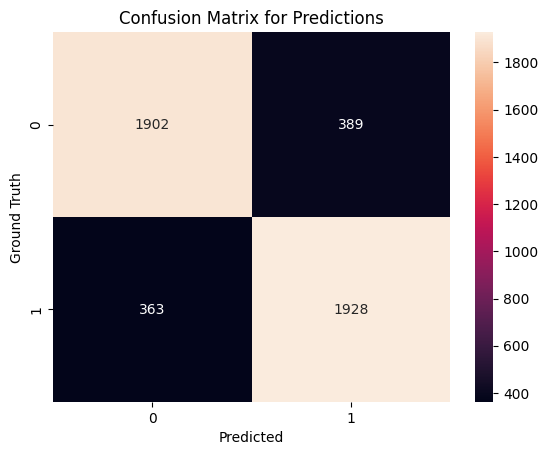

In [38]:
# plot the confusion matrix

cm = confusion_matrix(y_true, y_pred) # create confusion matrix

sns.heatmap(cm, annot=True, fmt='d') # plot the confusion matrix
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix for Predictions')
plt.show()